In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv
from joblib import Parallel, delayed

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


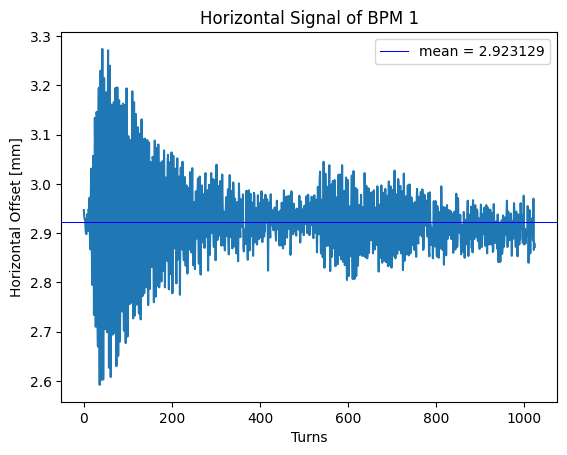

Standard deviation of First Vertical BPM = 0.14039846131415454


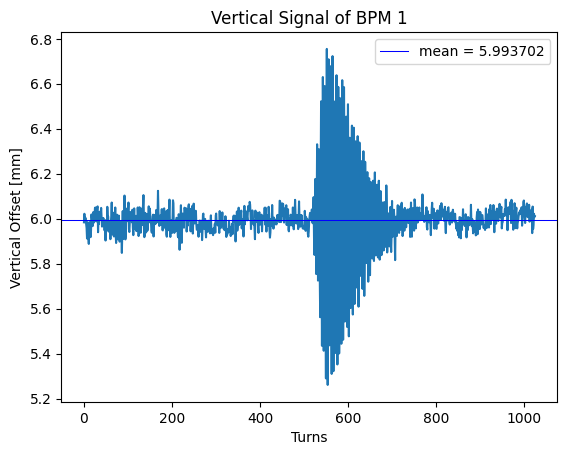

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


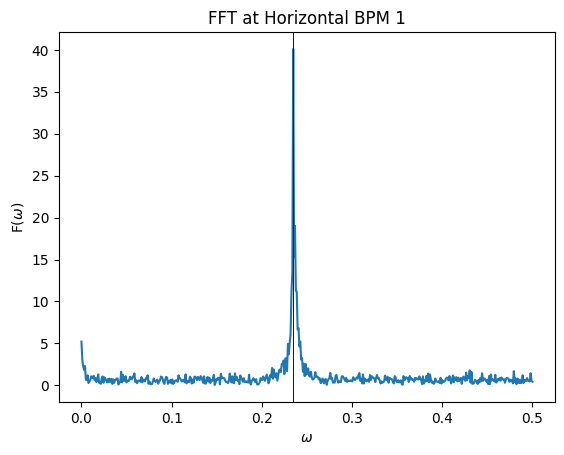

0.22896281800391388


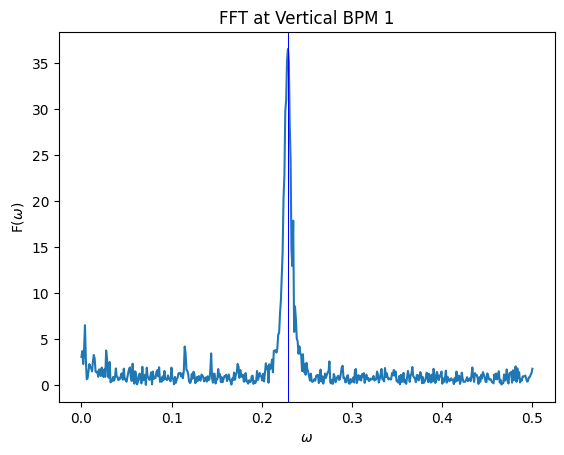

In [5]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


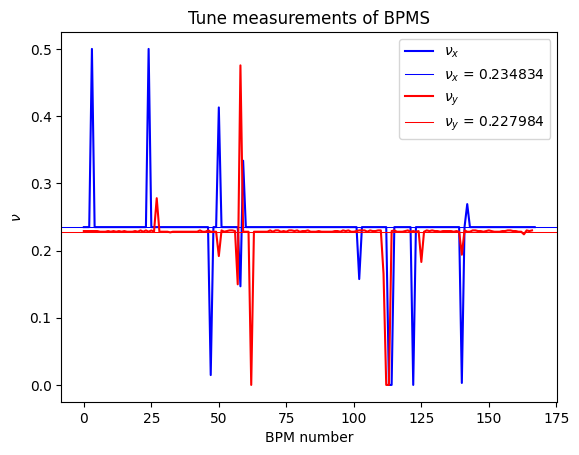

In [6]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

# Monte Carlo-Markov Chain Metropolis Hastings Method to find Amplitude

In [12]:
#Monte Carlo-Markov Chain Metropolis Hastings Functions by Yue Hao
def model(x0, x0p, xc, tunex, eps_sr, eps_nl, xisige, nvs, phis, Nturn=N_turns):
    alpha = 0
    beta = 1
    turns = np.arange(Nturn)
    phi = 2*np.pi*tunex
    
    cs = np.cos(turns*phi)
    sn = np.sin(turns*phi)
    m11 = cs + alpha*sn
    m12 = beta*sn
    
    alpha = 2*xisige*np.sin(np.pi*nvs*turns + phis)/nvs
    alpha02 = (2*xisige*np.sin(phis)/nvs)**2
    decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
    return (m11*(x0 - xc) + m12*x0p)*decay + xc

def log_likelihood(theta, sigma, data):
    
    predicted_data = model(*theta, len(data)) 
    diff = predicted_data-data
    ss = sigma[0]*sigma[0]+sigma[1]*sigma[1]*data*data
    
    return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


def metropolis_hastings(lf, data, iters, pinitials, p_step,
                        sinitials=[1e-4,1e-4], s_step=[1e-4,1e-4]):
    psamples = np.zeros((iters, len(pinitials)))
    ssamples = np.zeros((iters, 2))
    p = np.array(pinitials)
    s = np.array(sinitials)
    pstep = np.array(p_step)
    sstep = np.array(s_step)
    changed = False
    old_lh = lf(p,s, data)
    i = 0
    while i<iters:
        p_n = p + np.random.normal(size=len(pinitials))*pstep
        s_n = s + np.random.normal(size=len(sinitials))*sstep
        if p_n[4] < 0: # SR_eps  > 0
            continue
        if p_n[5] < 0: # nl_eps  > 0
            continue
        if p_n[6] < 0: # xi*sige > 0
            continue
        if p_n[7] <= 0: # nuz > 0
            continue
        if p_n[8] > np.pi:
            p_n[8] -= 2*np.pi
        if p_n[8] < -np.pi: 
            p_n[8] += 2*np.pi
        if s_n[0] < 0: # error rms size >0
            continue
        if s_n[1] < 0: # error rms size >0
            continue
        if changed:
            #old_lh=lf(p,s, data)
            old_lh = new_lh
            
        new_lh = lf(p_n,s_n, data)#-((p_n[0]-data[0])*(p_n[0]-data[0])/2/s_n/s_n+np.log(s_n))#*len(data)
        if np.log(np.random.rand()+1.0e-10) < new_lh - old_lh:
            p,s = p_n,s_n
            changed = True
        else:
            changed = False
        psamples[i] = p
        ssamples[i] = s
        i += 1
    return psamples, ssamples

In [13]:
def MCMCMH_result(nrow, ncol, Theta_names, bpm, parr, plane, Tbtdata):
    N_var = len(Theta_names)
    N_iter = len(parr)
    fig, Ax = plt.subplots(nrow, ncol*2, gridspec_kw = {'width_ratios':[5, 1]*ncol}, figsize=(12, 8))
    fig.suptitle('Full Model')
    split = N_iter//2
    x_iter = np.linspace(0, N_iter//1000, N_iter)
    Center = []
    Stddev = []

    for i in range(nrow):
        for j in range(ncol):
            if i*ncol + j >= N_var:
                break
            target = parr.T[i*ncol + j]
            Ax[i][j*2].set_xlabel("Thousand Iterations")
            Ax[i][j*2].set_ylabel(Theta_names[i*ncol + j])
            Ax[i][j*2].plot(x_iter, target)
            Ax[i][j*2].axvspan(split/1000, N_iter/1000, alpha = 0.1, color = 'c')
            Ax[i][j*2].axvline(split/1000, color = 'c', alpha = 0.1)
            center, stddev = np.average(target[split:]), np.std(target[split:])
            Center.append(center)
            Stddev.append(stddev)

            hist_data,_,_ = Ax[i][j*2 + 1].hist(target[split:], orientation='horizontal', density=True, color='c', bins=7)
            Ax[i][j*2 + 1].set_xlim([0, np.max(hist_data)*1.1])
            Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])
            Ax[i][j*2 + 1].get_yaxis().set_visible(False)


    plt.subplots_adjust(wspace=0.0)
    plt.show()
    
    Center = np.array(Center)
    Stddev = np.array(Stddev)

    data_model = model(*Center, N_turns)
    interval = 500
    if plane == 'x': 
        initial = 35
        diff = Tbtdata[bpm, initial: interval + initial] - data_model[: interval] + Center[2]
        plt.plot(Tbtdata[bpm, initial: interval + initial], label = "data")
        
        plt.plot(data_model[:interval], label = "model", alpha = .75)
        plt.plot(diff[:interval], label = "difference", alpha = .5)
        
    else: 
        initial = 535
        stop_i = len(Tbtdata[bpm]) - initial
        diff = Tbtdata[bpm, initial: ] - data_model[: stop_i] + Center[2]

        plt.plot(Tbtdata[bpm, initial: ], label = "data")
        plt.plot(data_model[: stop_i], label = "model", alpha = .75)
        plt.plot(diff, label = "difference", alpha = .5)

    plt.legend()
    plt.show()

In [551]:
# Initial conditions for Horizontal BPMs
pinitials = [BPMx0[0], 0.0, BPMx0_mean, BPMx0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 35

pinitials[4] = 0.0018
pinitials[5] = 0.0006
pinitials[6] = 0.00073
pinitials[7] = 1e-2
pinitials[8] = 1
p_step[4] = 1e-5
p_step[5] = 1e-5
p_step[6] = 1e-4
p_step[7] = 1e-4
p_step[8] = 3e-2
N_iter = 200000

# Run MCMCMH Simulation for Horizontal BPMs
# begin = time.time()
# # parr : iters x 11; sarr = iters x 2
# parr, sarr = metropolis_hastings(log_likelihood, BPMx0[initial: N_turns//2 + initial], N_iter, 
#                               pinitials, p_step, sinitials, s_step)
# end = time.time()
# print("Time elapsed for full model:", end - begin)
begin = time.time()
res = Parallel(n_jobs=-2)(delayed(metropolis_hastings)(log_likelihood, BPMx0[initial: N_turns//2 + initial], N_iter, 
                              pinitials, p_step, sinitials, s_step) for x in range(1))
end = time.time()
print("Time elapsed for full model:", end - begin)
parr, sarr = res[0]

Time elapsed for full model: 34.26282000541687


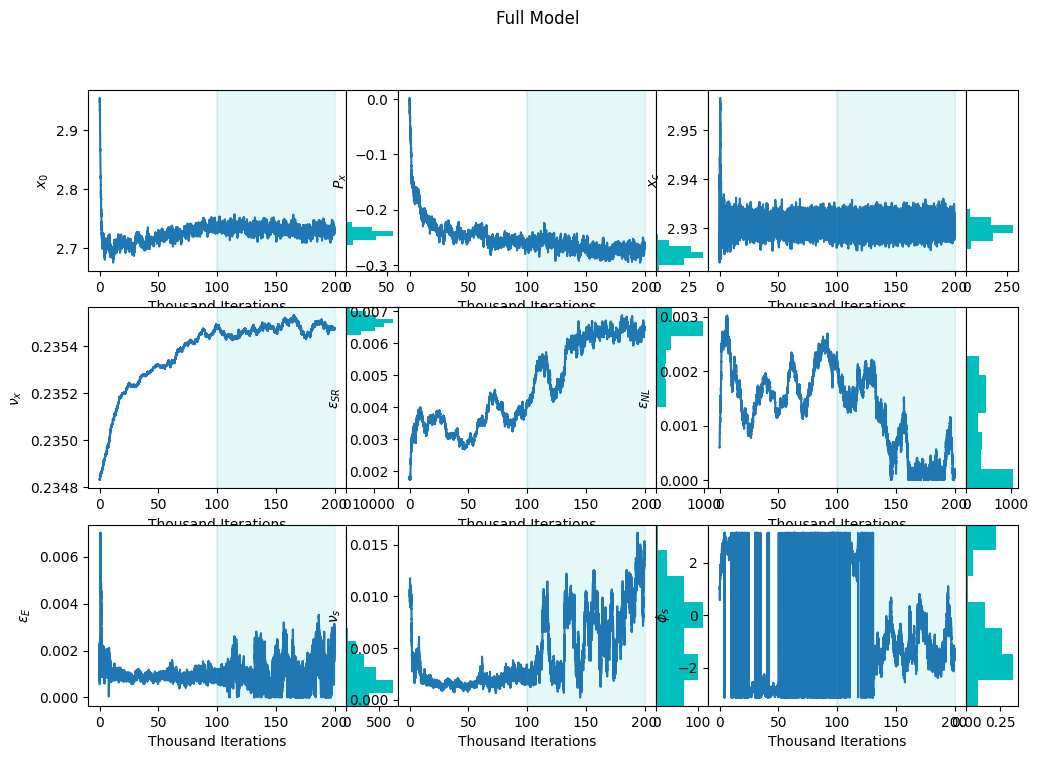

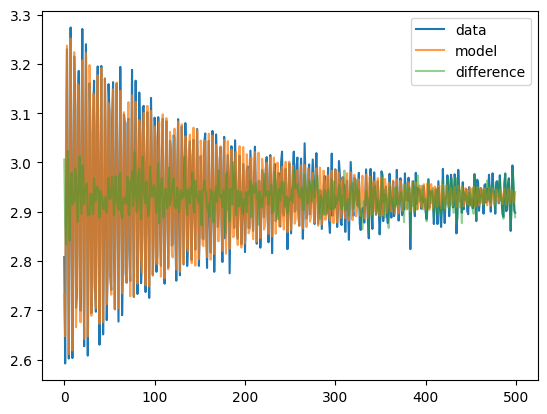

In [552]:
# Look at how variables change with # iterations
nrow = 3
ncol = 3
Theta_names = [r"$x_0$", r"$P_x$", r"$x_c$", r"$\nu_x$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
MCMCMH_result(nrow, ncol, Theta_names, 0, parr, 'x', BPMx)

In [553]:
# Initial conditions for Vertical BPMs
BPMY0 = np.abs(fft.rfft(BPMy[0])[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
pinitials = [BPMy[0, 0], 0.0, np.mean(BPMy[0]), BPMy0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 535

pinitials[4] = 0.0018
pinitials[5] = 0.0006
pinitials[6] = 0.00073
pinitials[7] = 1e-2
pinitials[8] = 1
p_step[4] = 1e-5
p_step[5] = 1e-5
p_step[6] = 1e-4
p_step[7] = 1e-4
p_step[8] = 3e-2
N_iter = 200000

# Run MCMCMH Simulation for Vertical BPMs
begin = time.time()
# parr : iters x 11; sarr = iters x 2
parr, sarr = metropolis_hastings(log_likelihood, BPMy0[initial: ], N_iter, 
                              pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for full model:", end - begin)

/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:15: RuntimeWarning: overflow encountered in exp
  decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in multiply
  return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


Time elapsed for full model: 30.237513780593872


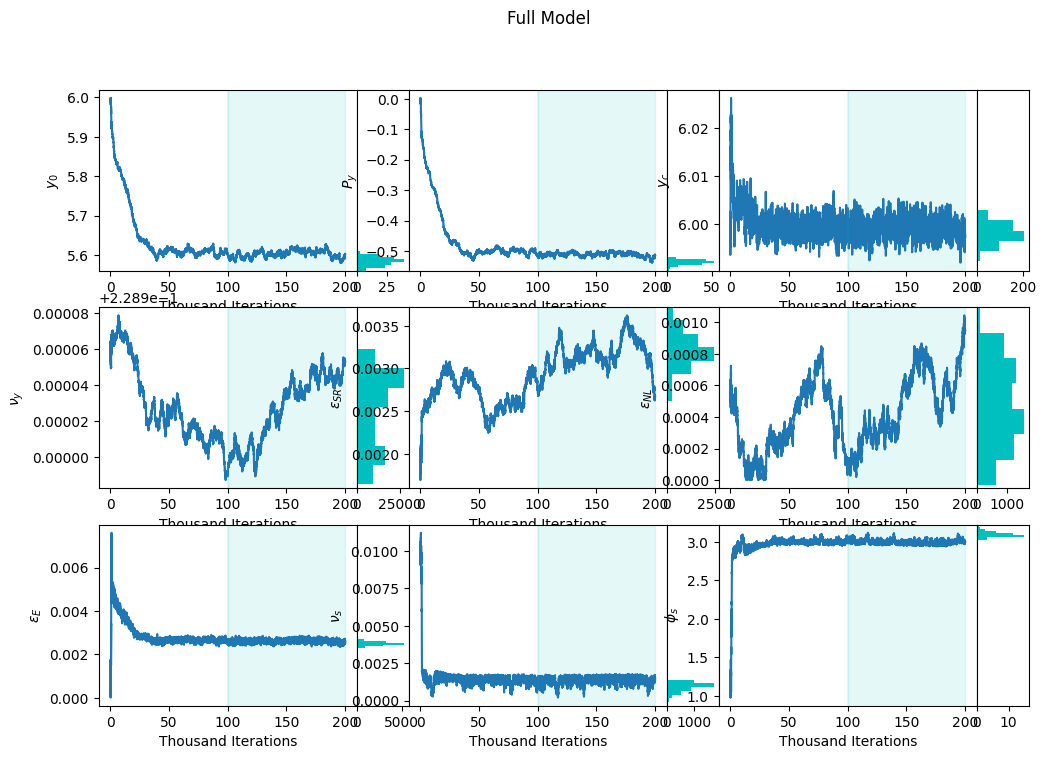

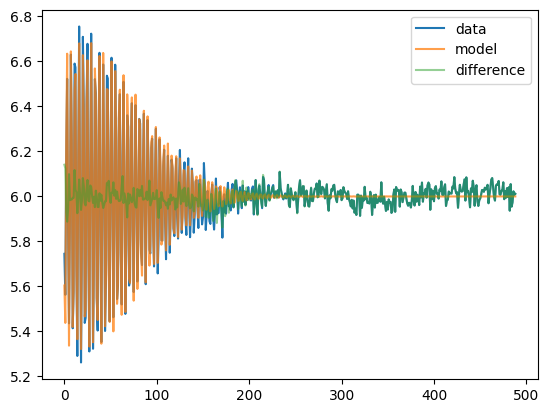

In [562]:
# Look at how variables change with # iterations
nrow = 3
ncol = 3
Theta_names = [r"$y_0$", r"$P_y$", r"$y_c$", r"$\nu_y$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
MCMCMH_result(nrow, ncol, Theta_names, 0, parr, 'y', BPMy)

In [17]:
# Run the following two cells if you already have data
def Jbeta(X, Px, N_BPMs, Bad_bpms):
    res = X**2 + Px**2

    # Get rid of bad bpms
    for i in Bad_bpms:
        # Look for the nearest good bpm neighbors and take the average:
        lo, hi = i, i
        while lo in Bad_bpms: 
            lo -= 1
            if lo < 0: lo = N_BPMs - 1
        while hi in Bad_bpms: 
            hi += 1
            if hi >= N_BPMs: hi = 0
        res[i] = (res[lo] + res[hi])/2
    return res

#Error Propagation
def Jbeta_error(X, Px, X_err, Px_err, N_BPMs, Bad_bpms, err_lim):
    A = np.sqrt(Jbeta(X, Px, N_BPMs, Bad_bpms))
    error = X_err**2*(X/A)**2 + Px_err**2*(Px/A)**2
    LargeErrorBPM = np.zeros(len(X))
    for i in range(len(error)):
        if error[i] > err_lim:
            LargeErrorBPM[i] = 1
    return np.sqrt(error), LargeErrorBPM

In [448]:
# https://github.com/yngvem/parallelising-python

N_iter = 150
N_iter_MC = 100000
def bpm_amp_data(bpm, N_iter_MC, N_iter):
    BPMXi = np.abs(fft.rfft(BPMx[bpm])[1:])
    BPMxi_Tune_scipy = Omega[np.argmax(BPMXi)]
    pinitials = [BPMx[bpm, 0], 0.0, np.mean(BPMx[bpm]), BPMxi_Tune_scipy, 1.8e-3,  6e-4, 7.3e-4, 1e-2, 1]
    p_step = [1e-3, 1e-3, 1e-3, 5e-7, 1e-5, 1e-5, 1e-4, 1e-4, 3e-2]
    sinitials = [1e-2, 0e-2]
    s_step = [2e-4, 0e-3]
    initial = 35
    # parr : iters x 11; sarr = iters x 2
    begin = time.time()
    Data = Parallel(n_jobs=-2)(delayed(metropolis_hastings)(log_likelihood, BPMx[bpm, initial: N_turns//2 + initial], 
                                                                 N_iter_MC, pinitials, p_step, sinitials, s_step) for x in range(N_iter))
    end = time.time()
    print("Time elapsed for horizontal BPM %d for %d iterations:"%(bpm, N_iter), end - begin)
    print("Avg time elapsed for horizontal BPM %d:"%bpm, (end - begin)/N_iter)
    for i, data in enumerate(Data):
        parr = data[0]
        filenamex_mean = "Theta_BPMx_mean_Data_200K_" + str(bpm)
        filenamex_err = "Theta_BPMx_err_Data_200K_" + str(bpm)
        with open(filenamex_mean, 'a') as csvfilex_mean:
            writerx_mean = csv.writer(csvfilex_mean, delimiter=',')
            writerx_mean.writerow(np.mean(parr.T[:, N_iter//2:], axis = 1))
        with open(filenamex_err, 'a') as csvfilex_err:
            writerx_err = csv.writer(csvfilex_err, delimiter=',')
            writerx_err.writerow(np.std(parr.T[:, N_iter//2:], axis = 1))

for bpm in range(26, 30):
    bpm_amp_data(bpm, N_iter_MC, N_iter)
print('done')


Time elapsed for horizontal BPM 26 for 150 iterations: 3126.33136510849
Avg time elapsed for horizontal BPM 26: 20.842209100723267
Time elapsed for horizontal BPM 27 for 150 iterations: 3313.127392053604
Avg time elapsed for horizontal BPM 27: 22.087515947024027


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:15: RuntimeWarning: overflow encountered in exp
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in multiply
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in divide
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in multiply
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in divide


Time elapsed for horizontal BPM 28 for 150 iterations: 3416.9609401226044
Avg time elapsed for horizontal BPM 28: 22.77973960081736


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in divide
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:24: RuntimeWarning: overflow encountered in multiply
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2816/2432908124.py:15: RuntimeWarning: overflow encountered in exp


Time elapsed for horizontal BPM 29 for 150 iterations: 3299.8952798843384
Avg time elapsed for horizontal BPM 29: 21.99930186589559
done


Through measurement variables $x_0$, $P_x$, $x_c$, the Amplitude function can be found:\
$A = \beta J = (x_0 - x_c)^2 + P_x^2$\
And the Error of the Amplitude function can be found using error propagation:\
$\sigma_A^2 = (\sigma_{x_0}^2 + \sigma_{x_c}^2)(2(x_0 - x_c))^2 + (\sigma_{P_x}2P_x)^2$

[1.35735873 0.16216947 0.17430641 1.27710566]
[0.04954211 0.00463075 0.00408965 0.0407975 ]


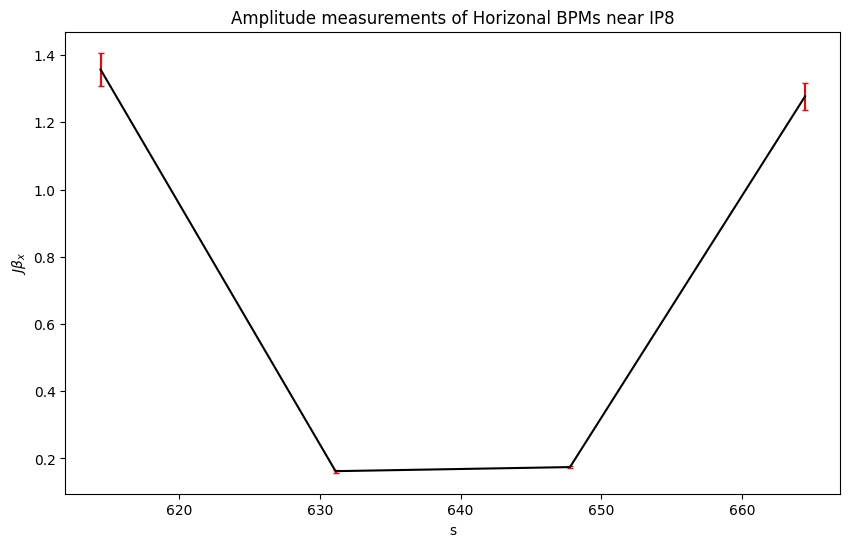

In [8]:
BPMs = [26, 27, 28, 29]
BPMx_Jbeta_Map = np.zeros(4)
BPMx_Jbeta_Map_err = np.zeros(4)
for i, bpm in enumerate(BPMs):
    filenamex_mean = "Theta_BPMx_mean_Data_200K_" + str(bpm)
    filenamex_err = "Theta_BPMx_err_Data_200K_" + str(bpm)
    with open(filenamex_mean, newline = "") as csvfilex_mean:
        Theta_final_x = np.array(list(csv.reader(csvfilex_mean, delimiter=',')), dtype=float)
        
    x0, x0p, xc = np.mean(Theta_final_x, axis = 0)[:3]
    x0_err, x0p_err, xc_err = np.std(Theta_final_x, axis = 0)[:3]
    A = (x0 - xc)**2 + x0p**2
    BPMx_Jbeta_Map[i] = A
    BPMx_Jbeta_Map_err[i] = np.sqrt((x0_err**2 + xc_err**2)*(2*(x0 - xc))**2 + x0p_err**2*(2*x0p)**2)
    
    
print(BPMx_Jbeta_Map)
print(BPMx_Jbeta_Map_err)
fig, ax = plt.subplots(figsize = (10, 6))
BPMx_Jbeta_Map_err_plot = np.copy(BPMx_Jbeta_Map_err)
ax.errorbar(S_xbpms[0, 26:30], BPMx_Jbeta_Map, yerr = BPMx_Jbeta_Map_err, color = 'k', ecolor = 'r', capsize = 2)
ax.set_xlabel("s")
ax.set_ylabel(r"$J\beta_x$")
ax.set_title(r"Amplitude measurements of Horizonal BPMs near IP8")
plt.show()
# .00003

Ratio between Will and Guillaume's Amplitude functions: [1.31728001 1.31600864 1.4664266  1.27947998]
Ratio between Chuyu and Guillaume's Amplitude functions: [11279.75360039 10519.6503664  10934.08799887 10973.60572818]
Ratio between Chuyu and Will's Amplitude functions: [8562.91258823 7993.60279078 7456.28048181 8576.61388867]
Relative Standard deviation between Will and Guillaume's: 0.05342332638983256
Relative Standard deviation between Chuyu and Guillaume's: 0.024751896272738886
Relative Standard deviation between Chuyu and Will's: 0.056851436001592905


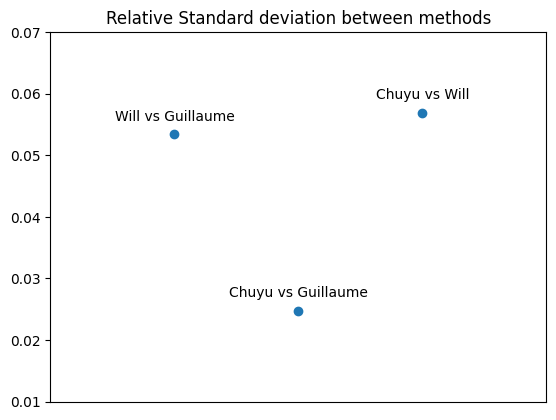

In [9]:
#Amplitude functions:
Amp_g = np.array([1.0150986958314416, 0.35103884172784544, 0.3447676598060305, 0.9990717247087637])**2
Amp_c = np.array([107.80975925254548, 36.004420545848014, 36.051040469066507, 104.65773803198772])**2

#Comparison between Amplitude functions:
Ratios_wg_amp = BPMx_Jbeta_Map/Amp_g
print("Ratio between Will and Guillaume's Amplitude functions:", Ratios_wg_amp)

Ratios_cg_amp = Amp_c/Amp_g
print("Ratio between Chuyu and Guillaume's Amplitude functions:",Ratios_cg_amp)

Ratios_cw_amp = Amp_c/BPMx_Jbeta_Map
print("Ratio between Chuyu and Will's Amplitude functions:",Ratios_cw_amp)

std_wg_rel = np.std(Ratios_wg_amp)/np.mean(Ratios_wg_amp)
std_cg_rel = np.std(Ratios_cg_amp)/np.mean(Ratios_cg_amp)
std_cw_rel = np.std(Ratios_cw_amp)/np.mean(Ratios_cw_amp)

Stddev_Rel = np.array([std_wg_rel, std_cg_rel, std_cw_rel])
Labels = ["Will vs Guillaume", "Chuyu vs Guillaume", "Chuyu vs Will"]
#Standard deviations
print("Relative Standard deviation between Will and Guillaume's:", std_wg_rel)
print("Relative Standard deviation between Chuyu and Guillaume's:", std_cg_rel)
print("Relative Standard deviation between Chuyu and Will's:", std_cw_rel)
plt.plot(Stddev_Rel, "o")
for x, y, text in zip([0, 1, 2], Stddev_Rel, Labels):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.title("Relative Standard deviation between methods")
plt.xlim([-1, 3])
plt.ylim([.01, .07])
plt.xticks([])
plt.show()

[ 0.17195096 -1.07532095 -0.04590932  0.235282    0.00288251  0.00162787
  0.00128861  0.00301235 -0.41393993]
0.36654630148398865


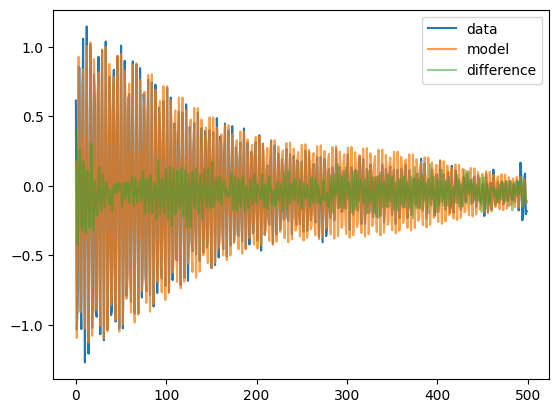

In [14]:
bpm1 = 26
filenamex_mean1 = "Theta_BPMx_mean_Data_100K_" + str(bpm1)
filenamex_err1 = "Theta_BPMx_err_Data_100K_" + str(bpm1)
with open(filenamex_mean1, newline = "") as csvfilex_mean1:
    Theta_final_x1 = np.array(list(csv.reader(csvfilex_mean1, delimiter=',')), dtype=float)
with open(filenamex_err1, newline = "") as csvfilex_err1:
    Theta_final_x_err1 = np.array(list(csv.reader(csvfilex_err1, delimiter=',')), dtype=float)
    
Theta_final_x1 = np.mean(Theta_final_x1, axis = 0)
Theta_final_x_err1 = np.mean(Theta_final_x_err1, axis = 0)
print(Theta_final_x1)
# turn1 = 10
# Theta_final_x1 = Theta_final_x1[turn1]
# Theta_final_x_err1 = Theta_final_x_err1[turn1]
x_model1 = model(*Theta_final_x1, N_turns)
interval = 500
initial = 35
diff = BPMx[bpm1, initial:] - x_model1[:len(BPMx[bpm1, initial:])] + Theta_final_x1[2]

plt.plot(BPMx[bpm1, initial: interval + initial], label = "data")
plt.plot(x_model1[:interval], label = "model", alpha = .75)
plt.plot(diff[:interval], label = "difference", alpha = .5)

# [r"$x_0$", r"$P_x$", r"$x_c$", r"$\nu_x$", r"$\epsilon_{SR}$", 
#              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
turns = np.linspace(initial, initial + interval, interval)
_, _, _, _, eps_sr, eps_nl, xisige, nvs, phis, = Theta_final_x1
alpha = 2*xisige*np.sin(np.pi*nvs*turns + phis)/nvs
alpha02 = (2*xisige*np.sin(phis)/nvs)**2
decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
print(np.mean(decay))

plt.legend()
plt.show()

1.1008020079524563


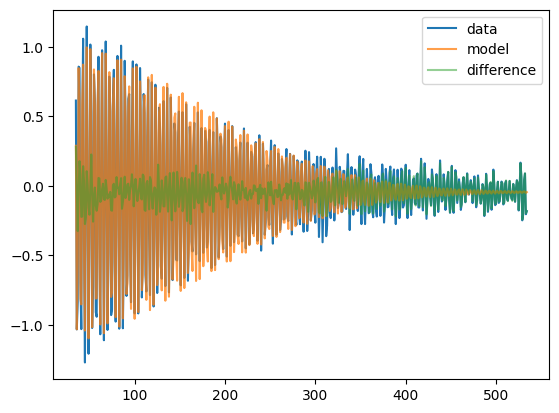

In [15]:
def test_func(x, a, b, c, d, e):
    #return a * np.cos((2.0*np.pi/b) * x + c) + d
    return a * np.exp(-2.0*(((np.pi*x)**2)/(b**2)))*np.cos(2.0*np.pi*c*x + d) + e

bpm1 = 26
BPMX27 = np.abs(fft.rfft(BPMx[bpm1])[1:])
BPMx27_Tune_scipy = Omega[np.argmax(BPMX27)]
pinitials = np.array([.5, 1/1.33887332e-03, BPMx27_Tune_scipy, 0, np.mean(BPMx[bpm1])])
xtrain = BPMx[bpm1, initial:initial + interval]
ttrain = np.linspace(initial, initial + interval - 1, interval)
theta_x_scipy, _ = optimize.curve_fit(test_func, ttrain, xtrain, pinitials)
x_model2 = test_func(ttrain, *theta_x_scipy)
diff2 = BPMx[bpm1, initial:initial + interval] - x_model2[:len(BPMx[bpm1, initial:])] + theta_x_scipy[-1]
print(abs(theta_x_scipy[0]))
plt.plot(ttrain, xtrain, label = "data")
plt.plot(ttrain, x_model2[:interval], label = "model", alpha = .75)
plt.plot(ttrain, diff2[:interval], label = "difference", alpha = .5)

plt.legend()
plt.show()

# Betatron Function around IP8

Determine $\alpha$ at g7-bx:

\begin{equation*}
M_{drift} = 
\begin{bmatrix}
C & S\\
C' & S'
\end{bmatrix}
=
\begin{bmatrix}
1 & L\\
0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
M_{twiss} = 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}

Assuming everything is a drift space:\
\begin{equation*}
\begin{bmatrix}
\beta_f \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_i \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}


1. $\Rightarrow \beta_f = \beta_i - 2L_{if}\alpha_i + L^2 \gamma_i$
2. $\Rightarrow \alpha_f = \alpha_i - L_{if}\gamma_i$
3. $\Rightarrow \gamma_f = \gamma_i$\
Where $\gamma_i = \frac{1 + \alpha_i^2}{\beta_i}$

From 1:\
$\beta_f = \beta_i - 2L_{if}\alpha_i + L^2 \frac{1 + \alpha_i^2}{\beta_i}$\
$0 = (\beta_i - \beta_f) - 2L_{if}\alpha_i + \frac{L^2}{\beta_i} + \frac{\alpha_i^2L^2}{\beta_i}$\
$0 = \frac{L^2}{\beta_i}\alpha_i^2 - 2L_{if}\alpha_i + \frac{L^2}{\beta_i} + (\beta_i - \beta_f)$

Solving the quadratic equation:\
$\Rightarrow \alpha_i = \frac{\beta_i}{L_{if}} \pm \sqrt{\frac{\beta_i\beta_f}{L_{if}^2} - 1}$

Between BPM 27 and BPM 28:\
$\alpha_{27} = \frac{\beta_{27}}{L_{27-28}} \pm \sqrt{\frac{\beta_{27}\beta_{28}}{L_{27-28}^2} - 1}$\
and $\gamma_{27} = \frac{1 + \alpha_{27}^2}{\beta_{27}}$

Between BPM 26 and BPM 27:\
$\gamma_{26} = \gamma_{27}$\
$\alpha_{27} = \alpha_{26} - L_{26-27}\gamma_{26}$\
$\Rightarrow \alpha_{26} = \alpha_{27} + L_{26-27}\gamma_{27}$\
$\Rightarrow 0 = \beta_{26} - \beta_{27} - 2L_{26-27}\alpha_{26} + L_{26-27}^2 \gamma_{26}$


And between BPM 28 and BPM 29:\
$\gamma_{28} = \gamma_{27}$\
$\alpha_{28} = \alpha_{27} - L_{27-28}\gamma_{27}$\
$\Rightarrow 0 = \beta_{28} - \beta_{29} - 2L_{28-29}\alpha_{28} + L_{28-29}^2 \gamma_{28}$

Since everything is known except J, solve for J using some root finding method

Finding amp matches with Guillaume, but not with finding J constant.\
something is wrong with root finding method or the math.

$x = A\exp(-2\frac{(\pi x)^2)}{b^2})\cos(2\pi c x + d)$

$K = \frac{\sum_{Arcs}\beta_{cDev}}{\sum_{Arcs}A^2}$

$\beta = A^2K$

$A = \max(FT(X - \bar{X}))$

$\beta_{i-1} + \frac{(l_2 - x)^2 - (l_1 + x)^2}{\beta_{i-1} - \beta_i} + (l_1 + x)^2\frac{\beta_{i - 1} - \beta_i}{(l_2 - x)^2 - (l_1 + x)^2} = 0$\
left bpm $ - l_1 \rightarrow s_{IP} - l_2 \rightarrow$ right bpm



In [27]:
s_bo7_b1, s_g7_bx, s_g8_bx, s_bi8_b1 = S_xbpms[0, 26:30]
L26_27, L27_28, L28_29 = abs(s_bo7_b1 - s_g7_bx), abs(s_g7_bx - s_g8_bx), abs(s_g8_bx - s_bi8_b1)
sIP8 = 639.445027949618

-140.22067474948858 43.86991492183277
43.86991492183277


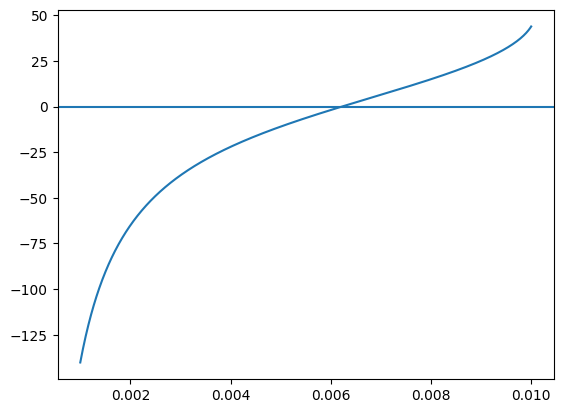

0.006223477772786283


In [23]:
def f1(J):
#     b26, b27, b28, b29 = (np.array([1.1008020079524563, 0.3805600403137374, 0.37423287771281516, 1.0828430720566957]))**2/J
    b26, b27, b28, b29 = BPMx_Jbeta_Map/J
    coeff = [L27_28**2/b27, -2*L27_28, L27_28**2/b27 + (b27 - b28)]
    alpha27 = np.max(np.roots(coeff))
    #alpha27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)
    gamma27 = (1 + alpha27**2)/b27
    
    gamma26 = gamma27
    alpha26 = alpha27 + L26_27*gamma26
    res_26_27 = b26 - b27 - 2*L26_27*alpha26 + L26_27**2*gamma26
    
    alpha28 = alpha27 - L27_28*gamma27
    gamma28 = (1 + alpha28**2)/b28
    res_28_29 = b28 - b29 - 2*L28_29*alpha28 + L28_29**2*gamma28
    #print(res_26_27, res_28_29)
    return res_26_27 #- res_28_29
#print(np.sqrt(BPMx_Jbeta_Map))
#print(np.array([1.1008020079524563, 0.3805600403137374, 0.37423287771281516, 1.0828430720566957])**2)
N_J = 1000
J_const = np.linspace(.001, .01, N_J)
Err = np.zeros(N_J)
for i, J in enumerate(J_const):
    Err[i] = f1(J)
f_J = Err[np.logical_not(np.isnan(Err))]
N_f_J = len(f_J)
print(f_J[0], f_J[-1])
print(np.max(f_J))
plt.plot(J_const, Err)
plt.axhline(y = 0)
plt.show()

J_opt = optimize.bisect(f1, J_const[0], J_const[-1])
print(J_opt)

In [24]:
# bo7_b1: bo7_b1, at = 614.421244783004;				MONITOR
# bo7_dh0_e1: bo7_dh0_e1, at = 615.348948544;			MULTIPOLE: knl := {0, 0, .0108589076109}
# bo7_dh0: bo7_dh0, at = 618.937914775074;			SBEND: l = 3.58896623069, angle := 0.0151837848507852
# bo7_dh0_e2: bo7_dh0_e2, at = 618.937914775074;		MULTIPOLE: knl := {0, 0, .00225526416281}
# g7_dhx_e1: g7_dhx_e1, at = 625.944808574;			MULTIPOLE: knl := {0, 8.22105866494e-06, -0.000117802159056}
# erdxmm07: erdxmm07, at = 625.944808574028;			MULTIPOLE: knl := {0, -9.61487905128617e-05}
# g7_dhx: g7_dhx, at = 629.645027949618;				SBEND: l = 3.70021937559, angle := -0.0188607908224827
# eldxmm07: eldxmm07, at = 629.645027949618;			MULTIPOLE: knl := {0, 0}
# g7_dhx_e2: g7_dhx_e2, at = 629.645027949618;		MULTIPOLE: knl := {0, 0, -0.00153539256346}
# g7_bx: g7_bx, at = 631.118653949618;				MONITOR
# g8_markx: g8_markx, at = 639.445027949618;			MARKER
# g8_bx: g8_bx, at = 647.771401949618;				MONITOR
# eldxpp08: eldxpp08, at = 649.245027949618;			MULTIPOLE: knl := {0, k1l_eldxmm08 = erdxmm08?}
# g8_dhx_e1: g8_dhx_e1, at = 649.24502795;			MULTIPOLE, knl := {0, 0, 0.00143231567429};
# g8_dhx: g8_dhx, at = 652.945247325208;				SBEND: l = 3.70021937559, angle := 0.0188603819104216
# erdxpp08: erdxpp08, at = 652.945247325208;			MULTIPOLE, knl := {0, -9.61446211961177e-05};
# g8_dhx_e2: g8_dhx_e2, at = 652.945247325208;		MULTIPOLE, knl := {0, -1.17384686729e-05, -0.000168207890575};
# bi8_dh0_e1: bi8_dh0_e1, at = 659.952141124;			MULTIPOLE: knl := {0, 0, -0.00169342951389};
# bi8_dh0: bi8_dh0, at = 663.541107354852;			SBEND, l = 3.58896623069, angle := -0.0151862520492059;
# bi8_dh0_e2: bi8_dh0_e2, at = 663.541107354852;		MULTIPOLE: knl := {0, 0, -0.010492570285};
# bi8_b1: bi8_b1, at = 664.468811116232;				MONITOR

def drift(L):
    return np.array([np.array([1, L]), np.array([0, 1])])

def sbend(L, phi):
    rho = L/phi
    return np.array([np.array([np.cos(phi), rho*np.sin(phi)]), 
                    np.array([-1/rho*np.sin(phi), np.cos(phi)])])
def Quad(k2l):
    return np.array([np.array([1, 0]), 
                    np.array([k2l, 1])])

def twiss_tran(M):
    C, S = M[0]
    Cp, Sp = M[1]
    return np.array([np.array([C**2, -2*C*S, S**2]), 
                    np.array([-C*Cp, Cp*S + Sp*C, -S*Sp]),
                    np.array([Cp**2, -2*Cp*Sp, Sp**2])])

s_bo7_b1 = 614.421244783004
s_bo7_dh0_e1 = 615.348948544
s_bo7_dh0_e2 = 618.937914775074
s_erdxmm07 = 625.944808574028
s_g7_dhx_e2 = 629.645027949618
s_g7_bx = 631.118653949618

s_g8_bx = 647.771401949618
s_g8_dhx_e1 = 649.24502795
s_erdxpp08 = 652.945247325208
s_bi8_dh0_e1 = 659.952141124
s_bi8_dh0_e2 = 663.541107354852
s_bi8_b1 = 664.468811116232

LD1 = s_bo7_dh0_e1 - s_bo7_b1
D1 = drift(LD1)

k2l_1E1 = 0
Q1E1 = Quad(k2l_1E1)

LB1 = s_bo7_dh0_e2 - s_bo7_dh0_e1
phiB1 = 0.0151837848507852
B1 = sbend(LB1, phiB1)

k2l_1E2 = 0
Q1E2 = Quad(k2l_1E2)

LD2 = s_erdxmm07 - s_bo7_dh0_e2
D2 = drift(LD2)

k2l_2E1 = 8.22105866494e-06
Q2E1 = Quad(k2l_2E1)

k2l_2eE1 = -9.61487905128617e-05
Q2eE1 = Quad(k2l_2eE1)

LB2 = s_g7_dhx_e2 - s_erdxmm07
phiB2 = -0.0188607908224827
B2 = sbend(LB2, phiB2)

k2l_2eE2 = 0
Q2eE2 = Quad(k2l_2eE2)

k2l_2E2 = 0
Q2E2 = Quad(k2l_2E2)

LD3 = s_g7_bx - s_g7_dhx_e2
D3 = drift(LD3)

M_26_27 = D3 @ (Q2E2 @ (Q2eE2 @ B2 @ Q2eE1) @ Q2E1) @ D2 @ (Q1E2 @ B1 @ Q1E1) @ D1
print(M_26_27)

Twiss_26_27 = twiss_tran(M_26_27)
print(Twiss_26_27)

LD4 = s_g8_dhx_e1 - s_g8_bx
D4 = drift(LD4)

k2l_3E1 = 0
Q3E1 = Quad(k2l_3E1)

k2l_3eE1 = 0
Q3eE1 = Quad(k2l_3eE1)

LB3 = s_erdxpp08 - s_g8_dhx_e1
phiB3 = 0.0188603819104216
B3 = sbend(LB3, phiB3)

k2l_3eE2 = -9.61446211961177e-05
Q3eE2 = Quad(k2l_3eE2)

k2l_3E2 = -1.17384686729e-05
Q3E2 = Quad(k2l_3E2)

LD5 = s_bi8_dh0_e1 - s_erdxpp08
D5 = drift(LD5)

k2l_4E1 = 0
Q4E1 = Quad(k2l_4E1)

LB4 = s_bi8_dh0_e2 - s_bi8_dh0_e1
phiB4 = -0.0151862520492059
B4 = sbend(LB4, phiB4)

k2l_4E2 = 0
Q4E2 = Quad(k2l_4E2)

LD6 = s_bi8_b1 - s_bi8_dh0_e2
D6 = drift(LD6)
M_28_29 = D6 @ (Q4E2 @ B4 @ Q4E1) @ D5 @ (Q3E2 @ (Q3eE2 @ B3 @ Q3eE1) @ Q3E1) @ D4
print(M_28_29)

Twiss_28_29 = twiss_tran(M_28_29)
print(Twiss_28_29)



[[ 9.98328360e-01  1.66856302e+01]
 [-2.48163646e-04  9.97526739e-01]]
[[ 9.96659514e-01 -3.33154757e+01  2.78410256e+02]
 [ 2.47748805e-04  9.91718466e-01 -1.66443623e+01]
 [ 6.15851951e-08  4.95099745e-04  9.95059595e-01]]
[[ 9.97296852e-01  1.66844401e+01]
 [-2.68120845e-04  9.98224904e-01]]
[[ 9.94601010e-01 -3.32786792e+01  2.78370543e+02]
 [ 2.67396075e-04  9.91053108e-01 -1.66548237e+01]
 [ 7.18887875e-08  5.35289809e-04  9.96452959e-01]]


409.3063618708012 -36.09747130540672
409.3063618708012


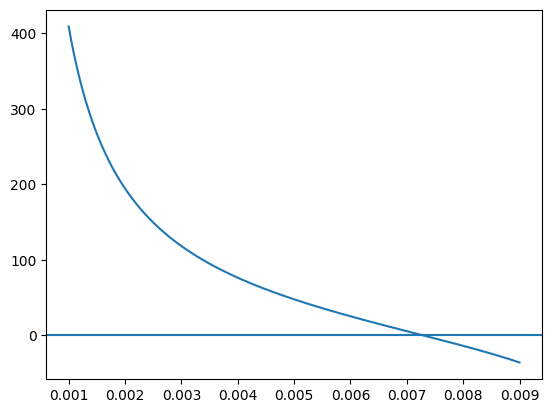

0.007279053384438157


In [25]:
def f2(J):
    b26, b27, b28, b29 = BPMx_Jbeta_Map/J
    coeff = [L27_28**2/b27, -2*L27_28, L27_28**2/b27 + (b27 - b28)]
    alpha27 = np.max(np.roots(coeff))
    gamma27 = (1 + alpha27**2)/b27
    
    A_26_27, B_26_27, C_26_27 = Twiss_26_27[0]
    _, D_26_27, E_26_27 = Twiss_26_27[1]
    _, _, F_26_27 = Twiss_26_27[2]
    gamma26 = gamma27/F_26_27
    alpha26 = (alpha27 - E_26_27*gamma26)/D_26_27
    res_26_27 = A_26_27*b26 - b27 + B_26_27*alpha26 + C_26_27*gamma26
    
    A_28_29, B_28_29, C_28_29 = Twiss_28_29[0]
#     _, D_28_29, E_28_29 = Twiss_28_29[1]
#     _, _, F_28_29 = Twiss_28_29[2]
    
    alpha28 = alpha27 - L27_28*gamma27
    gamma28 = (1 + alpha28**2)/b28
    res_28_29 = A_28_29*b28 - b29 + B_28_29*alpha28 + C_28_29*gamma28
    #print(res_26_27, res_28_29)
    return res_28_29 - res_26_27
    
N_J = 1000
J_const = np.linspace(.001, .009, N_J)
Err = np.zeros(N_J)
for i, J in enumerate(J_const):
    Err[i] = f2(J)
f_J = Err[np.logical_not(np.isnan(Err))]
N_f_J = len(f_J)
print(f_J[0], f_J[-1])
print(np.max(f_J))
plt.plot(J_const, Err)
plt.axhline(y = 0)
plt.show()

J_opt = optimize.bisect(f2, J_const[0], J_const[-1])
print(J_opt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


After shift:


<IPython.core.display.Math object>

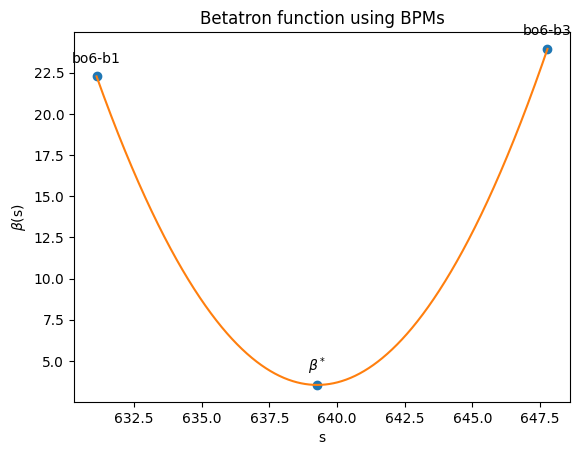

In [28]:
# Determine Betatron function:
beta_BPM26, beta_BPM27, beta_BPM28, beta_BPM29 = BPMx_Jbeta_Map/J_opt
alpha_BPM27 = beta_BPM27/L27_28 + np.sqrt(beta_BPM27*beta_BPM28/L27_28**2 - 1)
display(Math(r"\beta_{27} = %f"%beta_BPM27))
display(Math(r"\alpha_{27} = %f"%alpha_BPM27))
display(Math(r"\beta_{28} = %f"%beta_BPM28))
 
s_star = s_g7_bx + alpha_BPM27*beta_BPM27/(alpha_BPM27**2 + 1)
beta_star = beta_BPM27/(alpha_BPM27**2 + 1)
display(Math(r"\beta^* = %f"%beta_star))
display(Math(r"s^* = %f"%s_star))
display(Math(r"\Delta s^* = %f"%(s_star - sIP8)))

def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, s_star, beta_star, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - s_star, beta_BPM27, 0, beta_star, s_g8_bx - s_star, beta_BPM28)
print()
print("After shift:")
display(Math(r"%fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 'o')
for x, y, text in zip([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 
                      [Name_xbpms[1], r"$\beta^*$", Name_xbpms[2]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron)
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.show()

In [491]:
#Betatron functions:
Betatron_g = np.array([33.863676431314275, 11.71065020565156, 11.50144367596697, 33.32901692825202])**2
Betatron_c = np.array([1.49193540e+03, 1.66397010e+02, 1.66828203e+02, 1.40597162e+03])
Betatron_w = BPMx_Jbeta_Map/.00132

#Comparison between Betatron functions:
Ratios_wg_beta = Betatron_w/Betatron_g
print("Ratio between Will and Guillaume's Amplitude functions:", Ratios_wg_beta)

Ratios_cg_beta = Betatron_c/Betatron_g
print("Ratio between Chuyu and Guillaume's Amplitude functions:",Ratios_cg_beta)

Ratios_cw_beta = Betatron_c/Betatron_w
print("Ratio between Chuyu and Will's Amplitude functions:",Ratios_cw_beta)



Ratio between Will and Guillaume's Amplitude functions: [0.896711   0.89584555 0.99823944 0.87097941]
Ratio between Chuyu and Guillaume's Amplitude functions: [1.30101351 1.21334275 1.26114423 1.26570223]
Ratio between Chuyu and Will's Amplitude functions: [1.4508727  1.35441066 1.26336847 1.4531942 ]


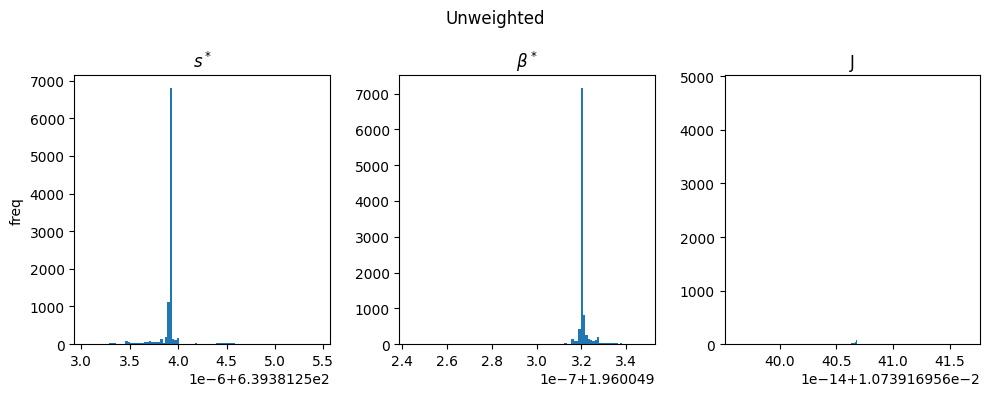

Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [162]:
bins = 100
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize = (10, 4))
plt.suptitle("Unweighted")
axs[0].hist(Sstar.flatten(), bins)
axs[1].hist(Bstar.flatten(), bins)
axs[2].hist(Jconst.flatten(), bins)
axs[0].set_ylabel("freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
plt.show()
print("Stats:")

display(Math("\overline{s}^* = %f \pm %f"% (np.mean(Sstar), np.std(Sstar))))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (np.mean(Bstar), np.std(Bstar))))
display(Math(r"\overline{J} = %f \pm %f"% (np.mean(Jconst), np.std(Jconst))))
display(Math(r"\Delta s^* = %f \pm %f"% (np.mean(Sstar) - sIP8, np.std(Sstar))))


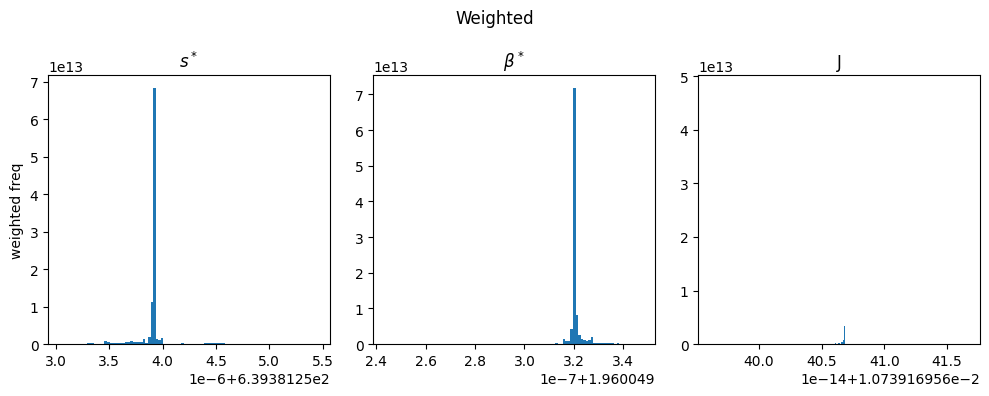

Weighted Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [163]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize = (10, 4))
plt.suptitle("Weighted")
weight = 1/(Err.flatten() + 1e-10)
freq_Sstar_weight, bins_Sstar_weight, _ = axs[0].hist(Sstar.flatten(), bins, weights = weight)#, density = True)
freq_Bstar_weight, bins_Bstar_weight, _ = axs[1].hist(Bstar.flatten(), bins, weights = weight)#, density = True)
freq_Jconst_weight, bins_Jconst_weight, _ = axs[2].hist(Jconst.flatten(), bins, weights = weight)#, density = True)
axs[0].set_ylabel("weighted freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
#axs[2].set_xlim([0, .1])
plt.show()

# Find mean and stddev of three plots
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)
print("Weighted Stats:")
sstar_avg_weighted, sstar_stddev_weighted = weighted_avg_and_std(bins_Sstar_weight[:-1], freq_Sstar_weight)
Bstar_avg_weighted, Bstar_stddev_weighted = weighted_avg_and_std(bins_Bstar_weight[:-1], freq_Bstar_weight)
Jconst_avg_weighted, Jconst_stddev_weighted = weighted_avg_and_std(bins_Jconst_weight[:-1], freq_Jconst_weight)
display(Math("\overline{s}^* = %f \pm %f"% (sstar_avg_weighted, sstar_stddev_weighted)))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (Bstar_avg_weighted, Bstar_stddev_weighted)))
display(Math(r"\overline{J} = %f \pm %f"% (Jconst_avg_weighted, Jconst_stddev_weighted)))
display(Math(r"\Delta s^* = %f \pm %f"% (sstar_avg_weighted - sIP8, sstar_stddev_weighted)))


## Error Propagation Calculation:
### On Betatron function:
$\beta = \frac{A}{J}$\
$\Rightarrow \sigma_{\beta}^2 = (\sigma_{A}\frac{\partial \beta}{\partial A})^2 + (\sigma_{J}\frac{\partial \beta}{\partial J})^2$\
$\Rightarrow \sigma_{\beta} = \sqrt{(\sigma_{A}\frac{1}{J})^2 + (\sigma_{J}\frac{-A}{J^2})^2}$

Then calculate partial derivatives of alpha:\
$\alpha_{27} = \frac{\beta_{27}}{L} + \sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}$\
$\Rightarrow \frac{\partial \alpha_{27}}{\partial \beta_{27}} = \frac{1}{L} + \frac{\beta_{28}}{2L^2\sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}}$\
& $\frac{\partial \alpha_{27}}{\partial \beta_{28}} = \frac{\beta_{27}}{2L^2\sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}}$

Using these, calculate error
### On $s^*$:
$s^* = s_{g7-bx} + \frac{\alpha_{27}\beta_{27}}{\alpha_{27}^2 + 1}$\
$\Rightarrow \frac{\partial s^*}{\partial \beta_{27}} = \frac{-\frac{\partial \alpha_{27}}{\partial \beta_{27}}\alpha_{27}^2\beta_{27} + {\frac{\partial \alpha_{27}}{\partial \beta_{27}}\beta_{27} + \alpha_{27}^3 + \alpha_{27}}}{(\alpha_{27}^2 + 1)^2}$\
& $\frac{\partial s^*}{\partial \beta_{28}} = \frac{-\frac{\partial \alpha_{27}}{\partial \beta_{28}}\beta_{27}(\alpha_{27}^2 - 1)}{(\alpha_{27}^2 + 1)^2}$
    
$\therefore \sigma_{s^*}^2 = (\sigma_{\beta_{27}}\frac{\partial s^*}{\partial \beta_{27}})^2 + (\sigma_{\beta_{28}}\frac{\partial s^*}{\partial \beta_{28}})^2$

### And $\beta^*$:
$\beta^* = \frac{\beta_{27}}{\alpha_{27}^2 + 1}$\
$\Rightarrow \frac{\partial \beta^*}{\partial \beta_{27}} = \frac{-2\frac{\partial \alpha_{27}}{\partial \beta_{27}}\alpha_{27}\beta_{27} + \alpha_{27}^2 + 1}{(\alpha_{27}^2 + 1)^2}$\
& $\frac{\partial \beta^*}{\partial \beta_{28}} = \frac{-2\frac{\partial \alpha_{27}}{\partial \beta_{28}}\alpha_{27}\beta_{27}}{(\alpha_{27}^2 + 1)^2}$

$\therefore \sigma_{\beta^*}^2 = (\sigma_{\beta_{27}}\frac{\partial \beta^*}{\partial \beta_{27}})^2 + (\sigma_{\beta_{28}}\frac{\partial \beta^*}{\partial \beta_{28}})^2$


<IPython.core.display.Math object>

Estimated values of Beta function at g7-bx & g8-bx:


<IPython.core.display.Math object>

Propagated error of Beta function at g7-bx & g8-bx based on varying J:
639.3812539124782 639.3812539044565
1.9600493201470237 1.9600493202105596


<IPython.core.display.Math object>

Estimated values of star values:


<IPython.core.display.Math object>

Propagated error of star values based on varying Beta function at g7-bx & g8-bx: 


<IPython.core.display.Math object>

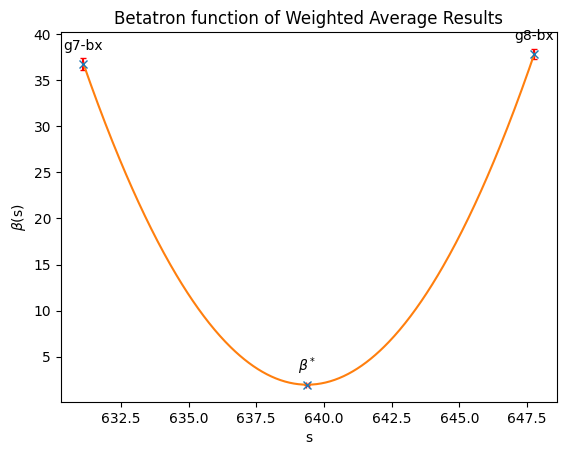

In [164]:
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C

beta_BPM27, beta_BPM28 = BPMx_Jbeta_Map[1:3]/Jconst_avg_weighted
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, sstar_avg_weighted, Bstar_avg_weighted, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - sstar_avg_weighted, beta_BPM27, 0, Bstar_avg_weighted, s_g8_bx - sstar_avg_weighted, beta_BPM28)
display(Math(r"\beta(s) = %fs^2 + %ds + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 500)
Betatron = A*s_space**2 + B*s_space + C
s_points = [s_g7_bx, sstar_avg_weighted, s_g8_bx]
b_points = [beta_BPM27, Bstar_avg_weighted, beta_BPM28]

for x, y, text in zip(s_points, b_points, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):
    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
err_ypoints = np.zeros(3)
err_xpoints = np.zeros(3)

## Error Propagation on beta(s) = A/J
## s_b = sqrt((s_A*(1/J))^2 + (s_J*(-A/J^2))^2)
err_ypoints_beta = np.sqrt((BPMx_Jbeta_Map_err[1:3]*(1/Jconst_avg_weighted))**2 + (Jconst_stddev_weighted*BPMx_Jbeta_Map[1:3]/Jconst_avg_weighted**2)**2)
def error_prop_bsstar(b27, b28, b27_err, b28_err):
    a27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)
    da27db27 = 1/L27_28 + b28/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    da27db28 = b27/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    
    s_star = s_g7_bx + a27*b27/(a27**2 + 1)
    ds_stardb27 = (-da27db27*a27**2*b27 + da27db27*b27 + a27**3 + a27)/(a27**2 + 1)**2
    ds_stardb28 = -da27db28*b27*(a27**2 - 1)/(a27**2 + 1)**2
    print(s_star, sstar_avg_weighted)
    
    beta_star = b27/(a27**2 + 1)
    db_stardb27 = (-2*da27db27*a27*b27 + a27**2 + 1)/(a27**2 + 1)**2
    db_stardb28 = -2*da27db28*a27*b27/(a27**2 + 1)**2
    print(beta_star, Bstar_avg_weighted)
    
    s_star_err_prop = np.sqrt((b27_err*ds_stardb27)**2 + (b28_err*ds_stardb28)**2)
    b_star_err_prop = np.sqrt((b27_err*db_stardb27)**2 + (b28_err*db_stardb28)**2)
    return s_star_err_prop, b_star_err_prop

print("Estimated values of Beta function at g7-bx & g8-bx:")
display(Math(r"\beta_{g7-bx} = %f; \beta_{g8-bx} = %f"%(beta_BPM27, beta_BPM28)))
print("Propagated error of Beta function at g7-bx & g8-bx based on varying J:")
s_star_err_prop, b_star_err_prop = error_prop_bsstar(beta_BPM27, beta_BPM28, *err_ypoints_beta)
display(Math(r"\sigma_{\beta_{g7-bx}} = %f; \sigma_{\beta_{g8-bx}} = %f"%(err_ypoints_beta[0], err_ypoints_beta[1])))

print("Estimated values of star values:")
display(Math(r"\Delta s^* = %f; \beta^* = %f"%(sstar_avg_weighted - sIP8, Bstar_avg_weighted)))
print("Propagated error of star values based on varying Beta function at g7-bx & g8-bx: ")
display(Math(r"\sigma_{s^*} = %f; \sigma_{\beta^*} = %f"%(s_star_err_prop, b_star_err_prop)))
err_ypoints[0] = err_ypoints_beta[0]
err_ypoints[1] = b_star_err_prop #Bstar_stddev_weighted
err_ypoints[2] = err_ypoints_beta[1]
err_xpoints[1] = s_star_err_prop #sstar_stddev_weighted

plt.errorbar(s_points, b_points, xerr = err_xpoints, yerr = err_ypoints, fmt = 'x', ecolor = 'r', capsize = 2)
plt.plot(s_space, Betatron)
plt.title("Betatron function of Weighted Average Results")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
#plt.set_xlim([639, 640])
#plt.set_ylim([0, 1])
plt.show()

## Comparing Guillaume's values with my values

After shift:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

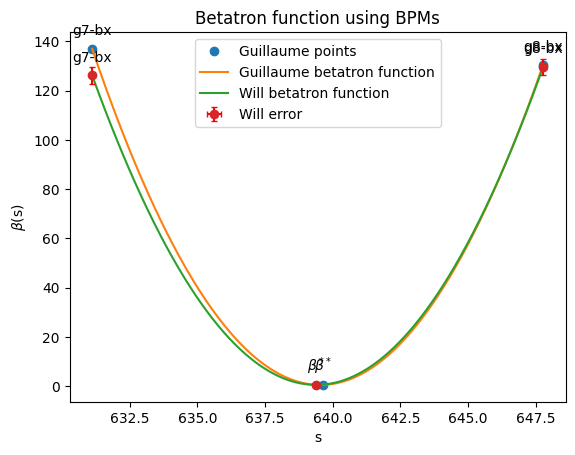

In [123]:
b1_g = 11.7**2

ss_g = .19918869 + sIP8
bs_g = .55506391

b2_g = 11.42**2

A_g, B_g, C_g = calc_parabola_vertex(s_g7_bx, b1_g, ss_g, bs_g, s_g8_bx, b2_g)
A_shift_g, B_shift_g, C_shift_g = calc_parabola_vertex(s_g7_bx - ss_g, b1_g, 0, bs_g, s_g8_bx - ss_g, b2_g)
print("After shift:")
display(Math(r"Guillaume: %fx^2 + %dx + %f"%(A_shift_g, B_shift_g, C_shift_g)))
display(Math(r"Will: %fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_points_g = [s_g7_bx, ss_g, s_g8_bx]
b_points_g = [b1_g, bs_g, b2_g]
plt.plot(s_points_g, b_points_g, 'o', label = "Guillaume points")
for x, y, text in zip(s_points_g, b_points_g, [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x, y, text in zip(s_points, b_points, [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

Betatron_g = A_g*s_space**2 + B_g*s_space + C_g
plt.plot(s_space, Betatron_g, label = "Guillaume betatron function")
plt.plot(s_space, Betatron, label = "Will betatron function")
plt.errorbar(s_points, b_points, xerr = err_xpoints, yerr = err_ypoints, fmt = 'o', ecolor = 'r', capsize = 2, label = "Will error")
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
# plt.xlim([639, 640])
# plt.ylim([0, 1])
plt.legend()
plt.show()